In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)
print(tf.test.is_gpu_available())
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

False
Num GPUs Available:  0


In [2]:
#Training parameters
BATCH_SIZE = 64
EPOCHS = 100
CORRECTION = 0.3

# Data path
file_path = './data/driving_log.csv'

### Preprocessing data

In [3]:
data_df = pd.read_csv(file_path)
data_df.head()

,center,left,right,steering,throttle,brake,speed
0,IMG/center_2016_12_01_13_30_48_287.jpg,IMG/left_2016_12_01_13_30_48_287.jpg,IMG/right_2016_12_01_13_30_48_287.jpg,0.0,0.0,0.0,22.148290
1,IMG/center_2016_12_01_13_30_48_404.jpg,IMG/left_2016_12_01_13_30_48_404.jpg,IMG/right_2016_12_01_13_30_48_404.jpg,0.0,0.0,0.0,21.879630
2,IMG/center_2016_12_01_13_31_12_937.jpg,IMG/left_2016_12_01_13_31_12_937.jpg,IMG/right_2016_12_01_13_31_12_937.jpg,0.0,0.0,0.0,1.453011
3,IMG/center_2016_12_01_13_31_13_037.jpg,IMG/left_2016_12_01_13_31_13_037.jpg,IMG/right_2016_12_01_13_31_13_037.jpg,0.0,0.0,0.0,1.438419
4,IMG/center_2016_12_01_13_31_13_177.jpg,IMG/left_2016_12_01_13_31_13_177.jpg,IMG/right_2016_12_01_13_31_13_177.jpg,0.0,0.0,0.0,1.418236


In [4]:
new_df = pd.DataFrame()
new_df['features'] = pd.concat([data_df['center'], data_df['left'], data_df['right']], ignore_index=True)
new_df['labels'] = pd.concat([data_df['steering'], data_df['steering']+CORRECTION, data_df['steering']-CORRECTION], ignore_index=True)
new_df.head()

,features,labels
0,IMG/center_2016_12_01_13_30_48_287.jpg,0.0
1,IMG/center_2016_12_01_13_30_48_404.jpg,0.0
2,IMG/center_2016_12_01_13_31_12_937.jpg,0.0
3,IMG/center_2016_12_01_13_31_13_037.jpg,0.0
4,IMG/center_2016_12_01_13_31_13_177.jpg,0.0


In [6]:
X = new_df['features'].map(lambda x: './data/'+x.strip())
y = new_df['labels'].values

In [8]:
X

0        ./data/IMG/center_2016_12_01_13_30_48_287.jpg
1        ./data/IMG/center_2016_12_01_13_30_48_404.jpg
2        ./data/IMG/center_2016_12_01_13_31_12_937.jpg
3        ./data/IMG/center_2016_12_01_13_31_13_037.jpg
4        ./data/IMG/center_2016_12_01_13_31_13_177.jpg
                             ...                      
24103     ./data/IMG/right_2016_12_01_13_46_38_745.jpg
24104     ./data/IMG/right_2016_12_01_13_46_38_802.jpg
24105     ./data/IMG/right_2016_12_01_13_46_38_846.jpg
24106     ./data/IMG/right_2016_12_01_13_46_38_922.jpg
24107     ./data/IMG/right_2016_12_01_13_46_38_947.jpg
Name: features, Length: 24108, dtype: object

In [9]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [10]:
def preprocess_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.cast(image, tf.float64)/255.0 - 0.5 
    return image

def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    return preprocess_image(image)

def load_and_preprocess_from_path_label(path, label):
    return load_and_preprocess_image(path), label

In [11]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_batches = train_ds.map(load_and_preprocess_from_path_label).batch(BATCH_SIZE).prefetch(1)

valid_ds = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))
validation_batches = valid_ds.map(load_and_preprocess_from_path_label).batch(BATCH_SIZE).prefetch(1)

### 1.Build model base on *Nvidia arXiv:1604.07316v*

In [12]:
model = tf.keras.Sequential([
    layers.Lambda(lambda x:(x/255.0)-0.5, input_shape=(160, 320, 3)),
    layers.Cropping2D(cropping=((70,25),(20,20)), input_shape=(160, 320, 3)),
    layers.Conv2D(24, kernel_size=(5, 5), strides =(2, 2), activation='relu'),
    layers.Conv2D(36, kernel_size=(5, 5), strides =(2, 2), activation='relu'),
    layers.Conv2D(48, kernel_size=(5, 5), strides =(2, 2), activation='relu'),   
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(100, activation='relu'),
    layers.Dense(50, activation='relu'),
    layers.Dense(10, activation='relu'),
    layers.Dense(1)
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 160, 320, 3)       0         
_________________________________________________________________
cropping2d (Cropping2D)      (None, 65, 280, 3)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 31, 138, 24)       1824      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 67, 36)        21636     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 32, 48)         43248     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 30, 64)         27712     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 1, 28, 64)         3

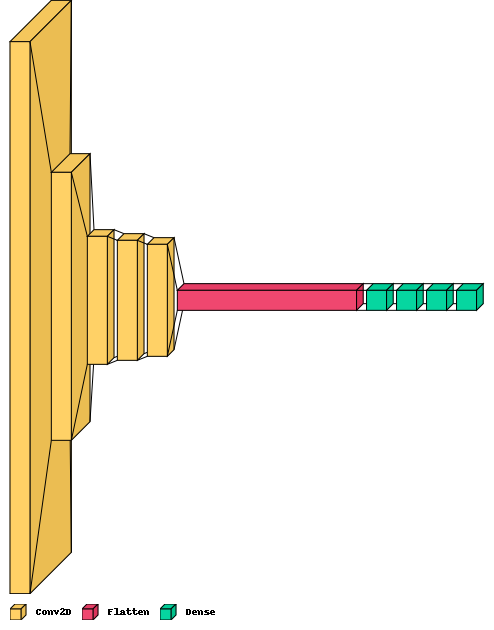

In [13]:
! pip install visualkeras
import visualkeras
visualkeras.layered_view(model, type_ignore=[layers.Lambda, layers.Cropping2D], legend=True)

In [14]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=4),
    ModelCheckpoint('{epoch:03d}.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
]

model.compile(optimizer='adam',loss='mse')

history = model.fit(train_batches, epochs=EPOCHS, validation_data=validation_batches, callbacks=callbacks)

Epoch 1/100
302/302 [==============================] - 285s 940ms/step - loss: 0.0755 - val_loss: 0.0773

Epoch 00001: val_loss improved from inf to 0.07733, saving model to 001.h5
Epoch 2/100
302/302 [==============================] - 312s 1s/step - loss: 0.0753 - val_loss: 0.0773

Epoch 00002: val_loss improved from 0.07733 to 0.07733, saving model to 002.h5
Epoch 3/100
302/302 [==============================] - 276s 915ms/step - loss: 0.0753 - val_loss: 0.0773

Epoch 00003: val_loss improved from 0.07733 to 0.07733, saving model to 003.h5
Epoch 4/100
302/302 [==============================] - 313s 1s/step - loss: 0.0753 - val_loss: 0.0773

Epoch 00004: val_loss improved from 0.07733 to 0.07733, saving model to 004.h5
Epoch 5/100
302/302 [==============================] - 113s 374ms/step - loss: 0.0753 - val_loss: 0.0773

Epoch 00005: val_loss improved from 0.07733 to 0.07733, saving model to 005.h5
Epoch 6/100
302/302 [==============================] - 76s 253ms/step - loss: 0.0753 

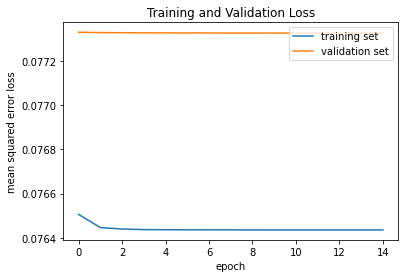

In [15]:
# Plot Training and Validation Graphs
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.title('Training and Validation Loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

### 2. Transfer Learning and set *trainable = True*

In [ ]:
#Pre-process image size
IMAGE_RES = 224

#Training parameters
BATCH_SIZE = 64
EPOCHS = 100

In [ ]:
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
feature_extractor = hub.KerasLayer(URL, input_shape=(IMAGE_RES, IMAGE_RES, 3), trainable=False, arguments=dict(batch_norm_momentum=0.997))
    
# Create a model with the pre-trained model and the new classification layer
mobilenet = tf.keras.Sequential([
    layers.Lambda(lambda x:(x/255.0)-0.5, input_shape=(160, 320, 3)),
    layers.Cropping2D(cropping=((70,25),(20,20)), input_shape=(160, 320, 3)),
    layers.experimental.preprocessing.Resizing(IMAGE_RES, IMAGE_RES, input_shape=(160, 320, 3)),
    feature_extractor,
    layers.Flatten(),
    layers.Dense(100, activation='relu'),
    layers.Dense(50, activation='relu'),
    layers.Dense(10, activation='relu'),
    layers.Dense(1)
])

mobilenet.summary()

In [ ]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=2),
    ModelCheckpoint('mobilenet_{epoch:03d}.h5', monitor='val_loss', verbose=0, save_best_only=True, mode='auto')
]


mobilenet.compile(
    optimizer='adam',
    loss='mse')

mobilenet_history = mobilenet.fit(train_batches, epochs=EPOCHS, validation_data=validation_batches, callbacks=callbacks)

In [ ]:
# Plot Training and Validation Graphs

loss = mobilenet_history.history['loss']
val_loss = mobilenet_history.history['val_loss']

plt.title('Training and Validation Loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()